#  Design of Complex Experiments using Mixed Integer Linear Programming
- this notebook provides example implementations for the four case studies in the article "Design of Complex Experiments using Mixed Integer Linear Programming"
- the included `milp` package contains various utility functions for each case study

In [1]:
import sys
sys.path.insert(0, '/home/jlg/storm/gbox/documents/writing/opt/milp_final_release')

In [2]:
from __future__ import print_function

import multiprocessing
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.integrate

import milp.program
from milp.examples import balanced_grouping
from milp.examples import stimulus_task_pairing
from milp.examples import structured_sampling
from milp.examples import trajectory_design

%matplotlib inline

In [3]:
milp.program.initialize_license()

Using license file /home/jlg/storm/bin/gurobi902/gurobi.lic
Academic license - for non-commercial use only


In [4]:
# figure formatting

# adapted from https://stackoverflow.com/a/39566040

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 96

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Example Problem 1: Balanced Grouping

In [5]:
def create_group_balance_problem(I, G, F):
    """
    
    ## Parameters
    - I: int number of items
    - G: int number of groups
    - F: (n_features, I)-shaped array of features
    """

    s = int(I / float(G))
    if s * G != I:
        raise Exception('G does not evenly divide I')
    
    program = milp.program.initialize_program()

    # decision variables
    for i in range(I):
        for g in range(G):
            milp.program.add_variable(
                program=program,
                name='X_{i},{g}'.format(i=i, g=g),
                variable_type=bool,
            )

    # each item should be placed in one group
    for i in range(I):
        coefficients = {'X_{i},{g}'.format(i=i, g=g): 1 for g in range(G)}
        milp.program.add_constraint(program, A_eq=coefficients, b_eq=1)

    # groups should have sizes  s1, ..., sg
    for g in range(G):
        coefficients = {'X_{i},{g}'.format(i=i, g=g): 1 for i in range(I)}
        milp.program.add_constraint(program, A_eq=coefficients, b_eq=s)

    # mean group features
    for f in range(F.shape[0]):
        for g in range(G):
            m_name = 'm_{f},{g}'.format(f=f, g=g)
            milp.program.add_variable(
                program=program,
                name=m_name,
                variable_type=float,
            )
            coefficients = {
                'X_{i},{g}'.format(i=i, g=g): F[f, i]
                for i in range(I)
            }
            coefficients[m_name] = -s
            milp.program.add_constraint(
                program=program,
                A_eq=coefficients,
                b_eq=0,
            )

    # global means
    global_means = []
    for f in range(F.shape[0]):
        global_mean = (1 / float(I)) * sum(F[f, i] for i in range(I))
        global_means.append(global_mean)
        milp.program.store_constant(
            program,
            'global_feature_mean_' + str(f), global_means[-1],
        )

    # balance terms in cost function
    for f in range(F.shape[0]):
        for g in range(G):
            coefficients = {'m_{f},{g}'.format(f=f, g=g): 1}
            milp.program.add_abs_cost_term(
                program=program,
                coefficients=coefficients,
                constant=-global_means[f],
            )
    
    return program

### create program

In [6]:
np.random.seed(0)

I = 360
G = 12
n_f = 1

# power distribution
F = np.zeros([n_f, I])
F[0, :] = 1 - np.random.power(3, size=(I))

F = (F * 1000)
F_reduce = F.astype(int)

program = create_group_balance_problem(
    I=I,
    G=G,
    F=F_reduce,
)

### solve

In [7]:
solution = milp.program.solve_MILP(program)

X_solution = milp.program.get_solution_variable(solution, 'X')
m_solution = milp.program.get_solution_variable(solution, 'm')
global_feature_mean = milp.program.get_solution_constant(
    solution,
    'global_feature_mean',
)

print()
print('X_solution', X_solution.shape)

program size:
- n_variables: 4344
- n_constraints: 408
- n_cost_function_terms: 12

X_solution (360, 12)


### find randomized solutions

In [8]:
n = 1e8

X_solution = X_solution.T.copy().T
balanced_grouping.set_comparison_context(F, X_solution, F.mean(1))
best_randomization = balanced_grouping.compute_randomization_solutions(
    F,
    n,
    processes=20,
)
randomization_ds = best_randomization['randomization_ds']

completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 500000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1000000 trials
completed 1500000 tr

In [9]:
best_randomization.keys()

dict_keys(['d', 'groups', 'randomization_ds', 't_generate', 't_evaluate'])

### plot result

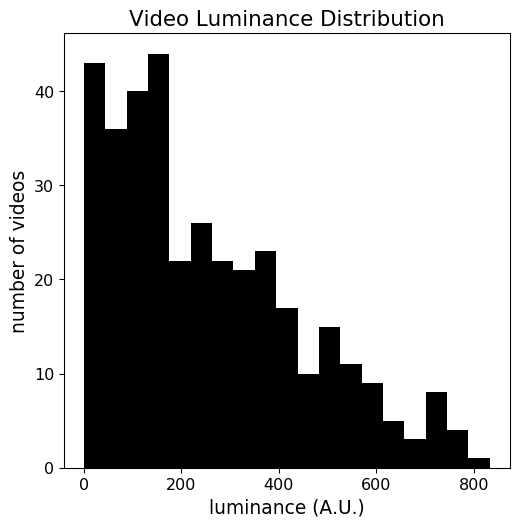

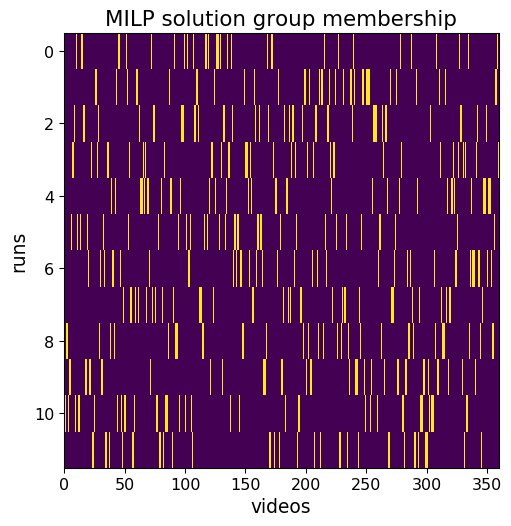

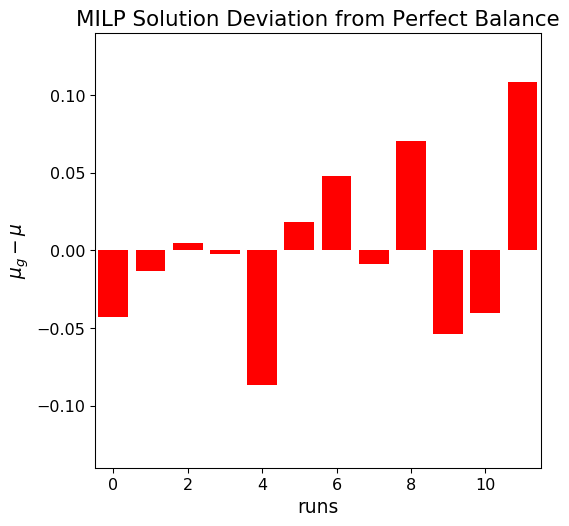

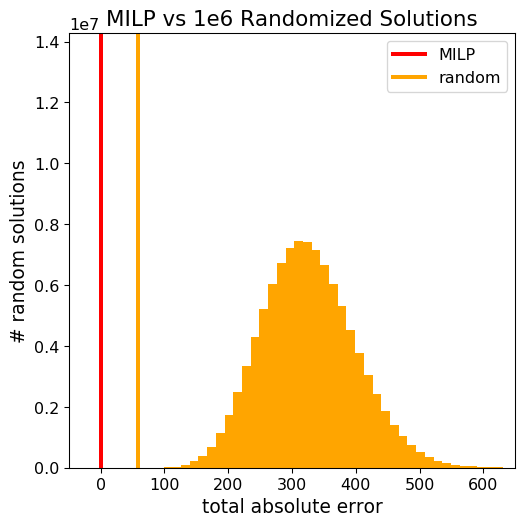

In [10]:
balanced_grouping.plot_grouping_separate_plots(
    F,
    X_solution,
    randomization_ds,
    n=n,
    figsize=[6, 6],
    randomization_axis=[-50, 650, 0, n / 7.0],
    show_title=True,
    show_labels=True,
    show_legend=True,
)

### How much better is MILP?

In [11]:
X_groups = [np.nonzero(X_solution[:, g])[0] for g in range(G)]
global_feature_means = F.mean(1)
group_evaluation = balanced_grouping.evaluate_groups(
    X_groups,
    F,
    global_feature_means
)
d_milp = group_evaluation['d_total']
ratio = best_randomization['d'] / d_milp
print(
    'the MILP solution has',
    ratio,
    'times smaller error than the best randomized solution',
)

the MILP solution has 116.23892083863578 times smaller error than the best randomized solution


# Example Problem 2: Stimulus-Task Pairing

In [12]:
def create_stimulus_condition_pairing_problem(n_trials, F, feature_probabilities):
    n_features, n_stimuli = F.shape
    n_tasks = n_features
    
    program = milp.program.initialize_program()

    # decision variables
    for i in range(n_stimuli):
        for g in range(n_tasks):
            milp.program.add_variable(
                program,
                'X_{i},{g}'.format(i=i, g=g),
                variable_type=bool,
            )

    trials_per_condition = int(n_trials / n_tasks)
    assert trials_per_condition * n_tasks == n_trials

    # constraint: match feature probabilities
    for g in range(n_tasks):
        for feature_value, feature_probability in feature_probabilities.items():
            
            feature_count = feature_probability * trials_per_condition
            
            variables_of_feature_value = {}
            for i in range(n_stimuli):
                if F[g, i] == feature_value:
                    variables_of_feature_value['X_{i},{g}'.format(i=i, g=g)] = 1

            mode = 'ceil_floor'
            if mode == 'exact':

                assert feature_count == int(feature_count)
                milp.program.add_constraint(
                    program,
                    A_eq=variables_of_feature_value,
                    b_eq=feature_count,
                )
            
            elif mode == 'ceil_floor':
            
                ceil = int(np.ceil(feature_count))
                floor = int(np.floor(feature_count))

                milp.program.add_constraint(
                    program,
                    A_lt=variables_of_feature_value,
                    b_lt=ceil,
                )
                milp.program.add_constraint(
                    program,
                    A_lt={k: -v for k, v in variables_of_feature_value.items()},
                    b_lt=-floor,
                )
            
            else:
                raise Exception(mode)
    
    # hard constrain equal usages per stimulus
    target_stimulus_repeats = (n_trials / float(n_stimuli))
    milp.program.store_constant(
        program=program,
        name='target_stimulus_repeats',
        value=target_stimulus_repeats,
    )
    for i in range(n_stimuli):
        coefficients = {}
        for g in range(n_tasks):
            coefficients['X_{i},{g}'.format(i=i, g=g)] = 1
        milp.program.add_constraint(
            program,
            A_eq=coefficients,
            b_eq=target_stimulus_repeats,
        )

    # for each task, balance the feature distributions to the population mean
    for g in range(n_tasks):
        for f in range(n_features):
            if g == f:
                continue

            coefficients = {}
            for i in range(n_stimuli):
                coefficients['X_{i},{g}'.format(i=i, g=g)] = F[f, i]

            milp.program.add_abs_cost_term(
                program,
                coefficients=coefficients,
                constant=-trials_per_condition * F[f, :].mean(),
            )

    return program

In [13]:
np.random.seed(0)

n_tasks = 14
n_stimuli = 700
n_trials = 2800

F_feature_values = [0, 1, 2]
F_feature_probabilities = [0.5, 0.25, 0.25]

F = np.random.choice(
    F_feature_values,
    p=np.array(F_feature_probabilities),
    size=(n_tasks, n_stimuli),
)

n_feature_values = len(F_feature_values)
feature_probabilities = {
    F_feature_values[i]: 1.0 / n_feature_values
    for i in range(n_feature_values)
}

program = create_stimulus_condition_pairing_problem(
    n_trials=n_trials,
    F=F,
    feature_probabilities=feature_probabilities,
)

### solve

In [14]:
solution = milp.program.solve_MILP(program)
X_solution = milp.program.get_solution_variable(solution, 'X')

print()
print('X_solution', X_solution.shape)

program size:
- n_variables: 9982
- n_constraints: 1148
- n_cost_function_terms: 182

X_solution (700, 14)


MILP solution


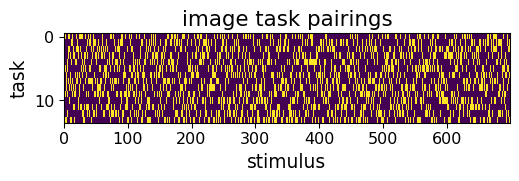

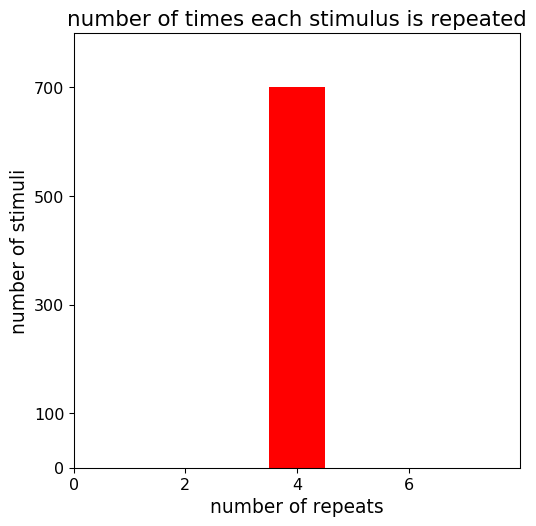

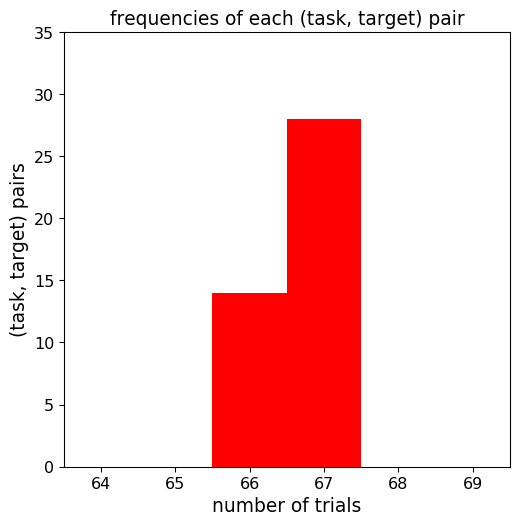

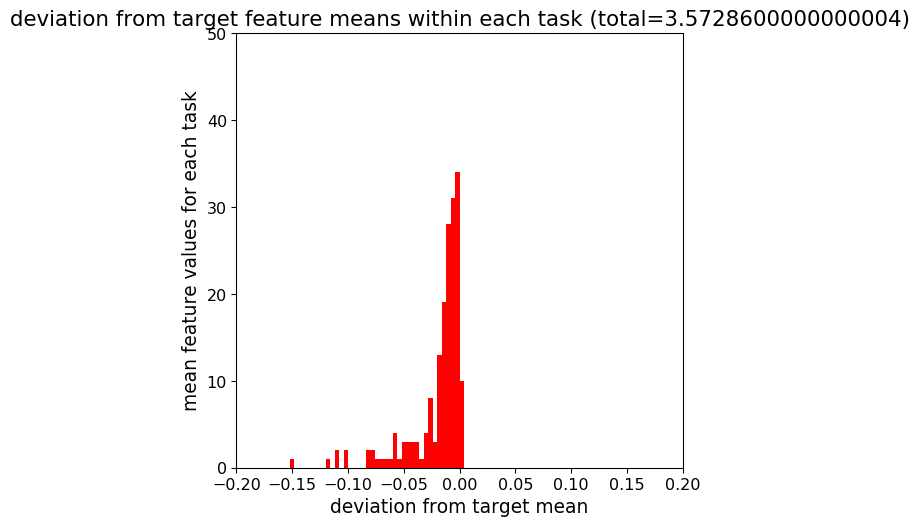

In [15]:
print('MILP solution')
stimulus_task_pairing.plot_as_separate_figures(
    X_solution,
    F,
    figsize=[6, 6],
    show_title=True,
    show_labels=True,
)

# Example Problem 3: Structured Hierarchical Sampling

In [16]:
def create_question_sample_space_problem(
        noun_semantic_tree,
        n_total_trials,
        n_question_templates,
        n_nouns_per_leaf_group,
    ):

    n_appearances_per_question_template = int(
        n_total_trials / n_question_templates
    )

    C, M = structured_sampling.get_coding_matrices(
        noun_semantic_tree=noun_semantic_tree,
        n_total_trials=n_total_trials,
        n_question_templates=n_question_templates,
        n_nouns_per_leaf_group=n_nouns_per_leaf_group,
    )
    CM = C.dot(M)

    T, G = C.shape
    G, N = M.shape

    program = milp.program.initialize_program()

    # decision variables
    for t in range(T):
        for n in range(N):
            if CM[t, n]:
                milp.program.add_variable(
                    program,
                    'P_{t},{n}'.format(t=t, n=n),
                    variable_type=bool,
                )

    # number of times each question template is used
    for t in range(T):
        A_eq = {}
        for variable in milp.program.get_variables(program, 'P', t, None):
            A_eq[variable] = 1
        milp.program.add_constraint(
            program,
            A_eq=A_eq,
            b_eq=n_appearances_per_question_template,
        )

    # minimize max(noun_usage) - min(noun_usage)
    milp.program.add_variable(program, 'maximum_noun_usage', int)
    milp.program.add_variable(program, 'minimum_noun_usage', int)
    for n in range(N):
        coefficients = {'maximum_noun_usage': -1}
        coefficients_negative = {'minimum_noun_usage': 1}
        for variable in milp.program.get_variables(program, 'P', None, n):
            coefficients[variable] = 1
            coefficients_negative[variable] = -1
        milp.program.add_constraint(program, A_lt=coefficients, b_lt=0)
        milp.program.add_constraint(program, A_lt=coefficients_negative, b_lt=0)
    milp.program.add_cost_terms(
        program=program,
        coefficients={'maximum_noun_usage': 1},
    )
    milp.program.add_cost_terms(
        program=program,
        coefficients={'minimum_noun_usage': -1},
    )

    # balance number of times each group is paired with each question
    for t in range(T):
        n_template_groups = C[t, :].sum()
        target_pairings_per_group = (
            n_appearances_per_question_template / float(n_template_groups)
        )

        for g in range(G):
            if C[t, g]:
                coefficients = {}
                for n in range(N):
                    if M[g, n]:
                        coefficients['P_{t},{n}'.format(t=t, n=n)] = 1

                if np.isclose(
                    target_pairings_per_group,
                    int(target_pairings_per_group),
                ):
                    milp.program.add_constraint(
                        program,
                        A_eq=coefficients,
                        b_eq=target_pairings_per_group,
                    )
                else:
                    ceil = np.ceil(target_pairings_per_group)
                    floor = np.floor(target_pairings_per_group)
                    milp.program.add_constraint(
                        program,
                        A_lt=coefficients,
                        b_lt=ceil,
                    )
                    milp.program.add_constraint(
                        program,
                        A_lt={k: -v for k, v in coefficients.items()},
                        b_lt=-floor,
                    )

    return program

### define parameters

In [17]:
noun_semantic_tree = {
    'Entities': {
        'People': {
            'Famous People': {},
            'People that the Subject Knows': {},
        },
        'Animals': {},
        'Corporations': {},
    },
    'Inanimate Objects': {
        'Vehicles': {},
        'Handheld Tools': {},
        'Clothing Items': {},
    },
    'Places': {
        'Countries': {},
        'Buildings': {
            'Famous Buildings': {},
            'Generic Buildings': {},
        },
    },
}

n_total_trials = 2400
n_question_templates = 120
n_nouns_per_leaf_group = 30

C, M = structured_sampling.get_coding_matrices(
    noun_semantic_tree=noun_semantic_tree,
    n_total_trials=n_total_trials,
    n_question_templates=n_question_templates,
    n_nouns_per_leaf_group=n_nouns_per_leaf_group,
)

program = create_question_sample_space_problem(
    noun_semantic_tree=noun_semantic_tree,
    n_total_trials=n_total_trials,
    n_question_templates=n_question_templates,
    n_nouns_per_leaf_group=n_nouns_per_leaf_group,
)

### solve

In [18]:
solution = milp.program.solve_MILP(program)
P_solution = milp.program.get_solution_variable(solution, 'P')

print()
print('P_solution', P_solution.shape)

program size:
- n_variables: 5762
- n_constraints: 960
- n_cost_function_terms: 2

P_solution (120, 300)


In [19]:
CM = C.dot(M)               
P = milp.program.get_solution_variable(solution=solution, name='P')
PMT = P.astype(int).dot(M.T)

### inspect solution

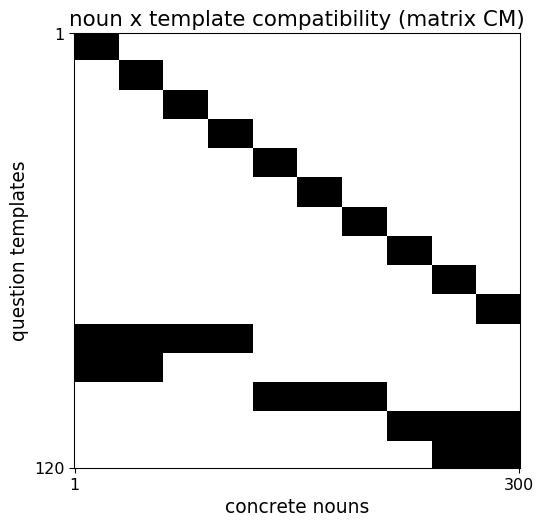

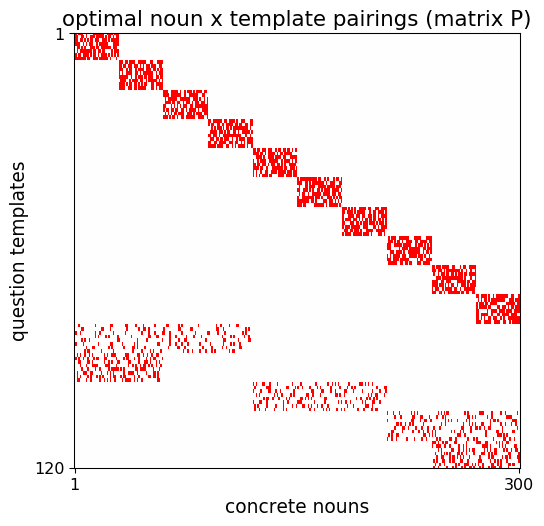

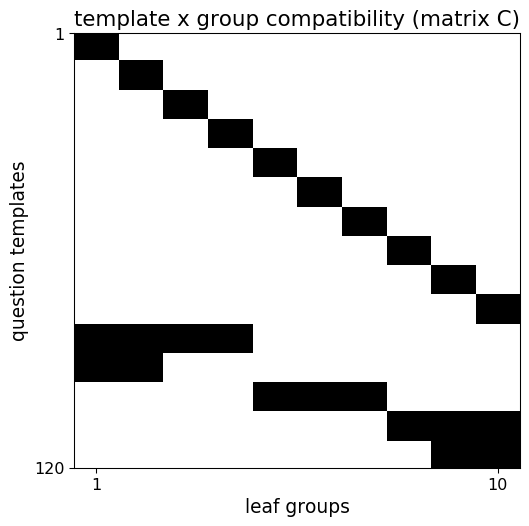

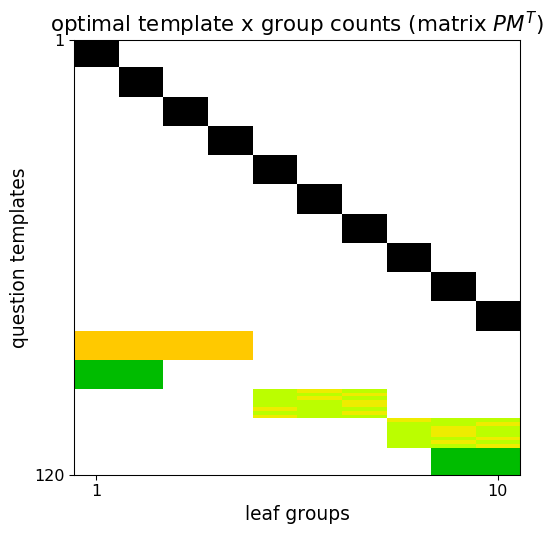

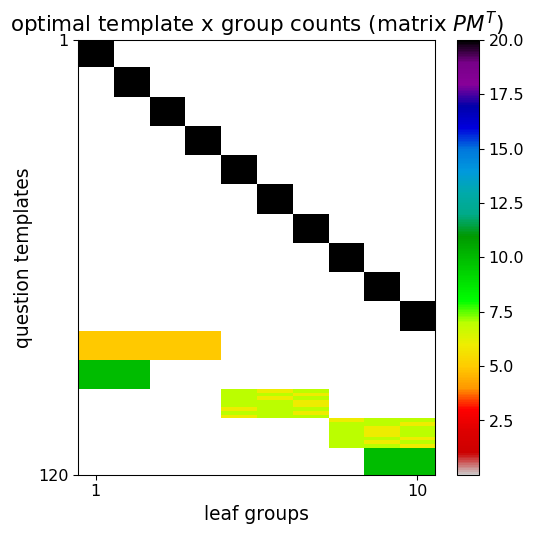

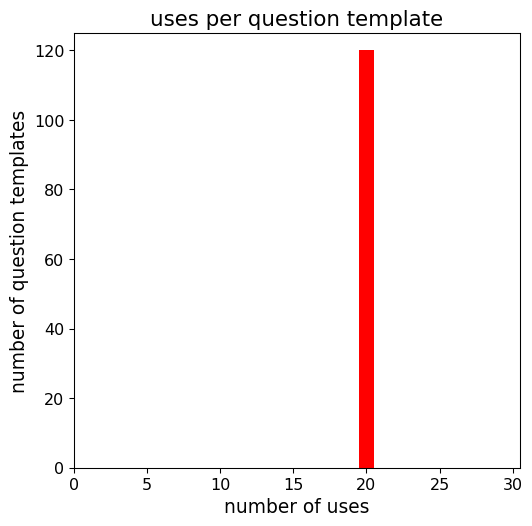

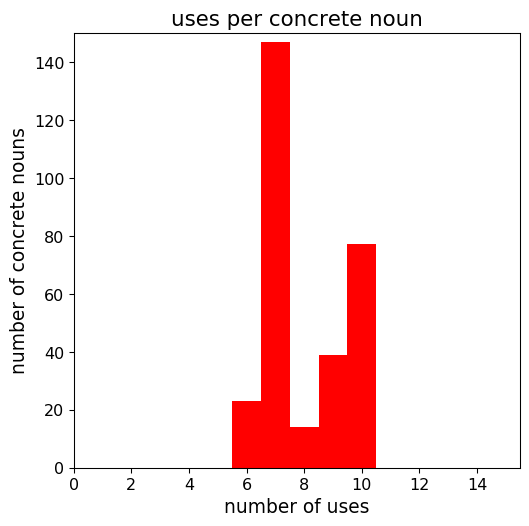

In [20]:
structured_sampling.plot_solution_summary_as_separate_figures(
    C,
    M,
    P,
    figsize=[6, 6],
    show_title=True,
    show_labels=True,
)

# Example Problem 4: Sequence Design For Navigation

n_trials: 80.0
mean_repeats_per_node: 3.2
mean_trial_distance: 0.25


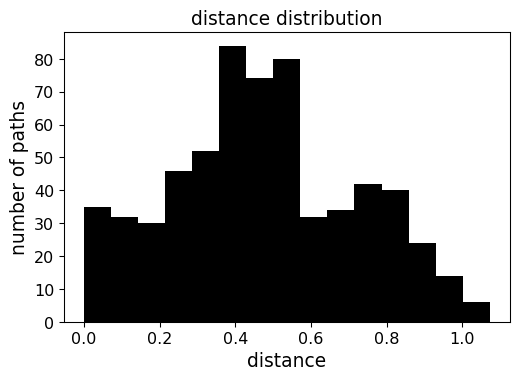

In [21]:
np.random.seed(0)

n_nodes = 25

x = np.random.rand(n_nodes)
y = np.random.rand(n_nodes)
distances = ((x - x[:, np.newaxis]) ** 2 + (y - y[:, np.newaxis]) ** 2) ** 0.5

t_per_distance = 2.0
t_mean_trial = 0.5

t_per_run = 10.0
n_runs = 4
n_trials = (n_runs * t_per_run) / float(t_mean_trial)
# n_trials = 100

mean_repeats_per_node = n_trials / float(n_nodes)
mean_trial_distance = t_mean_trial / t_per_distance

print('n_trials:', n_trials)
print('mean_repeats_per_node:', mean_repeats_per_node)
print('mean_trial_distance:', mean_trial_distance)


trajectory_design.plot_distance_distribution(distances)

### repeats per node

compute repeats per node

mean 3.199385156983983

count sum: 25
weighted count sum: 80


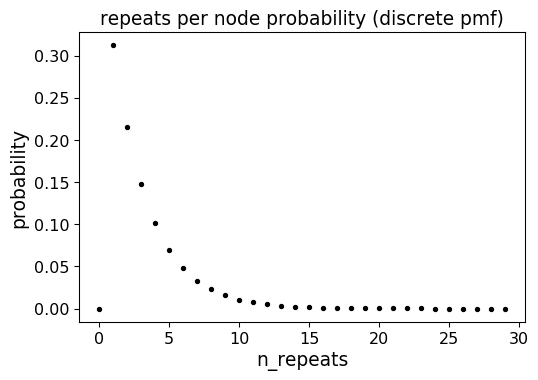

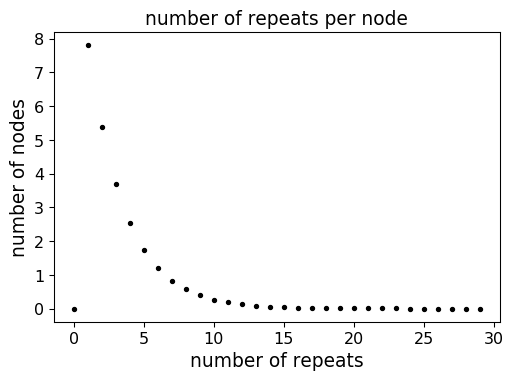

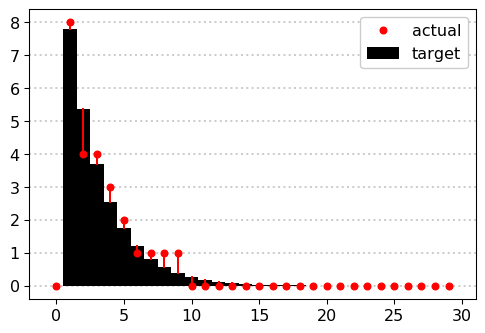

/home/jlg/storm/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


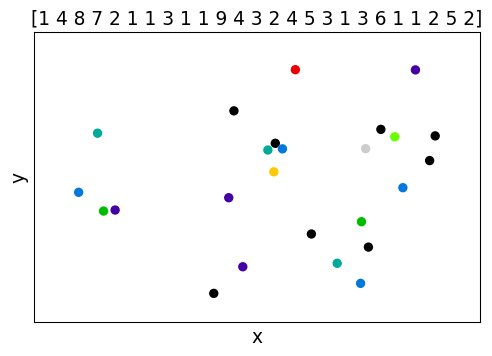

In [22]:
print('compute repeats per node')
print()

n_counts = 30
geometric_parameter = 1 / mean_repeats_per_node

n_repeats = np.arange(n_counts)
n_repeats_pmf = scipy.stats.geom.pmf(n_repeats, geometric_parameter)

repeat_counts = trajectory_design.compute_repeats(n_counts, n_nodes, n_trials)
visits_per_location = trajectory_design.compute_visits_per_location(
    repeat_counts
)

print('mean', (n_repeats_pmf * n_repeats).sum())
print()
print('count sum:', repeat_counts.sum())
print(
    'weighted count sum:',
    (repeat_counts * np.arange(repeat_counts.shape[0])).sum(),
)

trajectory_design.plot_node_repeats_pmf(n_repeats, n_repeats_pmf)
plt.show()
trajectory_design.plot_node_repeats_denormalized(
    n_repeats,
    n_repeats_pmf,
    n_nodes,
)
plt.show()
trajectory_design.plot_target_vs_actual_repeats_per_node(
    repeat_counts,
    n_repeats_pmf,
    n_nodes,
)
plt.show()
trajectory_design.plot_locations(
    x,
    y,
    colors=visits_per_location,
    title=visits_per_location,
    cmap='nipy_spectral',
)
plt.show()

### path length distribution

program size:
- n_variables: 20
- n_constraints: 21
- n_cost_function_terms: 10
target mean: 0.25
mean: 0.25


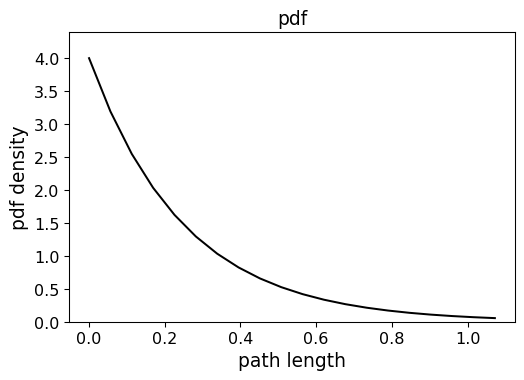

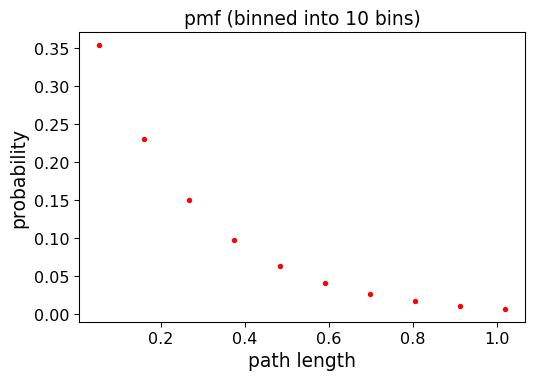

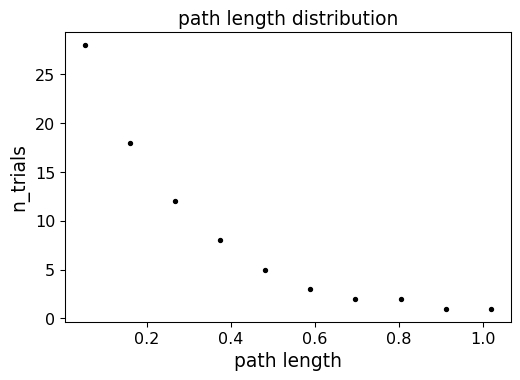

In [23]:
n_bins = 10

distance_pdf = trajectory_design.compute_target_path_length_pdf(
    distances,
    mean_trial_distance,
)
distance_pmf = trajectory_design.compute_target_path_length_pmf(
    n_bins,
    distances,
    distance_pdf,
)
discrete_path_distribution = trajectory_design.compute_target_path_length_discrete(
    distance_pmf,
    n_trials,
)

print('target mean:', mean_trial_distance)
print('mean:', distance_pdf['scipy_distribution'].mean())

trajectory_design.plot_distance_pdf(distance_pdf)
plt.show()
trajectory_design.plot_distance_pmf(distance_pmf)
plt.show()
trajectory_design.plot_discrete_path_distribution(discrete_path_distribution)
plt.show()

### compute path

In [24]:
trajectory = trajectory_design.compute_trajectory(
    visits_per_location=visits_per_location,
    distances=distances,
    target_path_length_distribution=discrete_path_distribution,
)

program size:
- n_variables: 6170
- n_constraints: 182
- n_cost_function_terms: 10

    eliminating subtours iteration 0 (sizes = [11, 41, 3, 17, 9, 3, 3])
    eliminating subtours iteration 1 (sizes = [18, 60, 3, 3])
    eliminating subtours iteration 2 (sizes = [76, 4, 3])
    eliminating subtours iteration 3 (sizes = [54, 12, 4, 3, 3, 3, 3, 3, 4])
    eliminating subtours iteration 4 (sizes = [71, 7, 5])
    eliminating subtours iteration 5 (sizes = [22, 9, 37, 10, 3, 3, 3])
    eliminating subtours iteration 6 (sizes = [26, 29, 5, 3, 3, 17, 4])
    eliminating subtours iteration 7 (sizes = [48, 12, 21, 3])
    eliminating subtours iteration 8 (sizes = [52, 23, 3, 3, 4])
    eliminating subtours iteration 9 (sizes = [34, 41, 4, 3, 3])
    eliminating subtours iteration 10 (sizes = [45, 5, 25, 3, 5, 3])
    eliminating subtours iteration 11 (sizes = [17, 40, 9, 4, 13, 3])
    eliminating subtours iteration 12 (sizes = [13, 52, 8, 3, 7, 3])
    eliminating subtours iteration 13 (sizes

### compute random paths

In [25]:
n_random = 10000000
# n_random = 100000

random_paths = trajectory_design.compute_random_paths(
    n_random=n_random,
    n_trials=n_trials,
    distances=distances,
    visits_per_location=visits_per_location,
    **discrete_path_distribution
)

for key, value in random_paths.items():
    print(key + ':', value)

best_path: [19 16 15 14 19 15 15  7 14  2  5  1 21 13 19  8 23 24 13 19  7 14  1 18
  1  2  2  3 23  7 14  0 23  3 10 16 23  2  9 10 12 11  3 12 22  1 18 15
 24 10  3  3 11  2  4 23 10  2 20 10 15 16 19 17 19 10 19 10 10  2  2  6
 11 10  3 22 11  4 18 12  3]
best_counts: [21  7 14  8  5  3  7 11  3  1]
best_error: 36
n_random: 10000000


### Plot Results

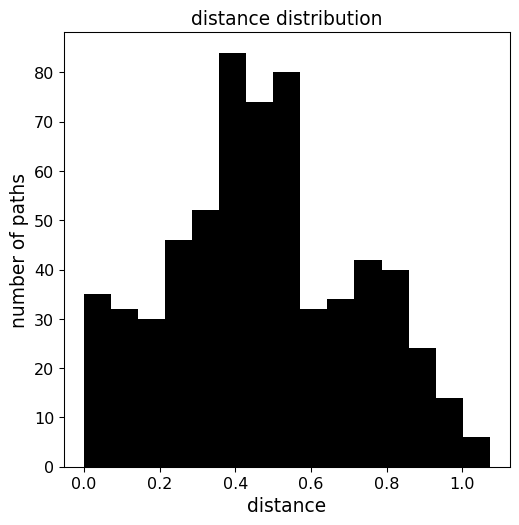

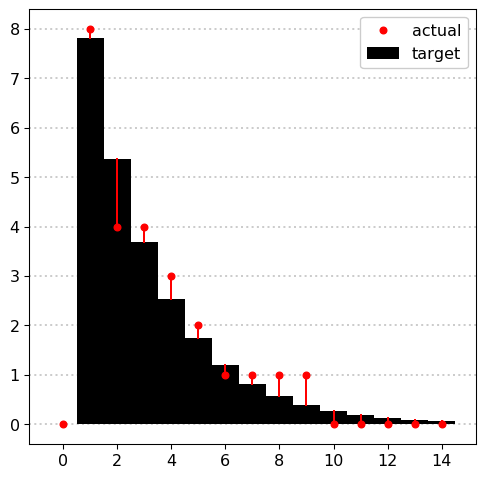

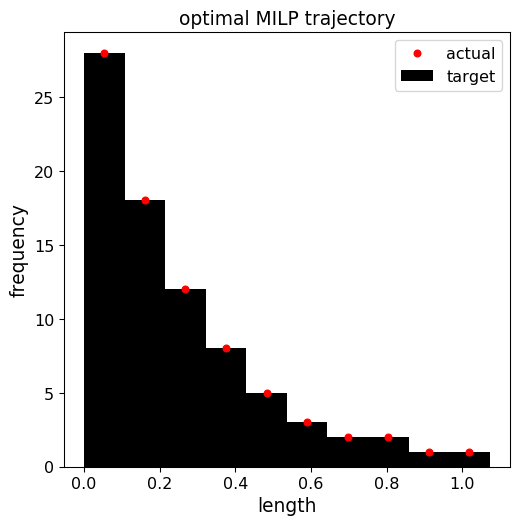

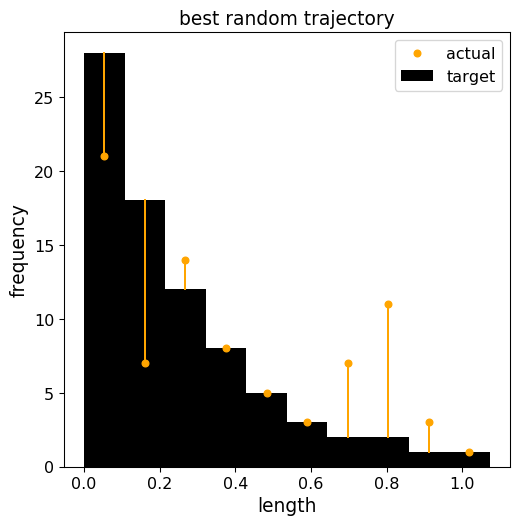

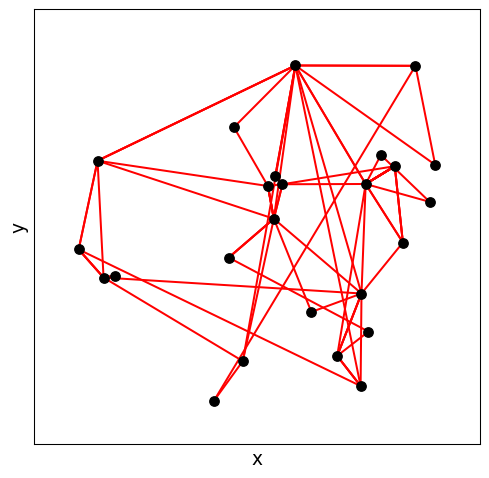

In [26]:
figsize = [6, 6]
n_shown_repeats = 15

trajectory_design.plot_summary(
    distances=distances,
    n_repeats=n_repeats,
    n_repeats_pmf=n_repeats_pmf,
    n_nodes=n_nodes,
    repeat_counts=repeat_counts,
    n_shown_repeats=n_shown_repeats,
    x=x,
    y=y,
    visits_per_location=visits_per_location,
    distance_pdf=distance_pdf,
    discrete_path_distribution=discrete_path_distribution,
    distance_pmf=distance_pmf,
    trajectory=trajectory,
    random_paths=random_paths,
    figsize=figsize,
    show_title=True,
    show_labels=True,
    show_legend=True,
    show_colorbar=True,
)